<a href="https://colab.research.google.com/github/ClaudiaSanchez/FFI2020_IIA/blob/master/CalibracionColoresAlpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Que nada esté hardcodeado. Que funcione con pocas imágenes y sólo un tipo de carne
*   Calcular el error de los colores con las diferencias de la paleta de calibración y la de muestra.
*   Colocar los boxplots de cada tipo de carne juntos, para comparar los métodos.
*   Elemento de lista

In [1]:
!pip install -q colour-science

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import csv
import colour
from scipy.optimize import differential_evolution

In [3]:
# Define the path of the images folder
folder_img_carne = "/content/drive/MyDrive/Mi_FFI/imagenes_carne"
folder_img_paleta = "/content/drive/MyDrive/Mi_FFI/imagenes_paletas"

# Set the target folder for the calibrated images
folder_img_cal = "/content/drive/MyDrive/Mi_FFI/imagenes_calibradas"
folder_pal_cal = "/content/drive/MyDrive/Mi_FFI/paletas_calibradas"

if not os.path.exists(folder_img_cal):
    os.mkdir(folder_img_cal)

if not os.path.exists(folder_pal_cal):
    os.mkdir(folder_pal_cal)

In [4]:
# Function to find circles in an image
def find_circles(paleta):
    gray = cv2.cvtColor(paleta, cv2.COLOR_RGB2GRAY)
    detected_circles = cv2.HoughCircles(gray, 
                        cv2.HOUGH_GRADIENT, 1, 20, param1 = 100,
                    param2 = 25, minRadius = 1, maxRadius = 25)

    if detected_circles is not None:
        detected_circles = np.uint16(np.around(detected_circles))

    return detected_circles[0]

# Function to sort detected circles and get the median of their colors
def getColorsMatrix(paleta,detected_circles):
    my_circles = deepcopy(detected_circles)
    circles_column_idx = np.argsort(my_circles[:,0])
    circ_sorted_x = deepcopy(my_circles[circles_column_idx,:])

    circ_split = np.array_split(circ_sorted_x,4)

    circ_sorted_y = np.zeros_like(circ_split)
    for k in range(len(circ_split)):
        circles_row_idx = np.argsort(circ_split[k][:,1])
        circ_sorted_y[k] = deepcopy(circ_split[k][circles_row_idx,:])
    
    rows,cols,_ = circ_sorted_y.shape
    my_circles = np.reshape(circ_sorted_y,(rows*cols,_))

    median_array = np.zeros((len(my_circles),3))
    for k in range(len(my_circles)):
        (x,y,r) = my_circles[k]
        
        median_r = np.median(paleta[y-(r//2):y+(r//2),x-(r//2):x+(r//2),0])
        median_g = np.median(paleta[y-(r//2):y+(r//2),x-(r//2):x+(r//2),1])
        median_b = np.median(paleta[y-(r//2):y+(r//2),x-(r//2):x+(r//2),2])
        
        median_array[k] = (median_r,median_g,median_b)
    
    return my_circles,median_array

In [5]:
# Function to get the error of the differential evolution individual
def error(ind,median_p,median_cal):
    ind = np.reshape(ind,(3,3))
    return np.sum(np.abs(median_cal-np.dot(median_p,ind)))

In [6]:
# List all the meat images
files = os.listdir(folder_img_carne)
files[:5]

['20210908_S01_9_c.JPG',
 '20210910_S01_7_c.JPG',
 '20210910_S01_6_c.JPG',
 '20210910_S01_8_c.JPG',
 '20210910_S01_9_c.JPG']

In [7]:
# Show the available methods and ours
methods = sorted(colour.COLOUR_CORRECTION_METHODS.keys())
print(methods)
methods.append("Differential Evolution")
print(methods)

['Cheung 2004', 'Finlayson 2015', 'Vandermonde']
['Cheung 2004', 'Finlayson 2015', 'Vandermonde', 'Differential Evolution']


In [8]:
# Select the method we are going to use
for method in methods:
    print("Method:",method)
    # Create the folders to store the calibrated images
    if not os.path.exists(folder_pal_cal+'/'+method):
        os.mkdir(folder_pal_cal+'/'+method)
    if not os.path.exists(folder_img_cal+'/'+method):
        os.mkdir(folder_img_cal+'/'+method)
    # Browse the files
    for file in files:
        # print("test image...")
        # Read one meat image
        img = cv2.imread(folder_img_carne+f"/{file}")
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        # Read the corresponding palette image
        img_paleta = cv2.imread(folder_img_paleta+f"/{file}")
        img_paleta = cv2.cvtColor(img_paleta,cv2.COLOR_BGR2RGB)
        # print("detect circles...")
        # Detect the circles in the palette
        detected_circles = find_circles(img_paleta)
        # print("get medians...")
        # Get the median of each color in the palette
        circles_p,median_p = getColorsMatrix(img_paleta,detected_circles)

        # print("calibration palette...")
        # Read the calibration palette
        paleta_calibracion = cv2.imread(folder_img_paleta+"/CALIBRACION.JPG")
        paleta_calibracion = cv2.cvtColor(paleta_calibracion,cv2.COLOR_BGR2RGB)
        # print("detect circles...")
        # Detect the circles in the calibration palette
        detected_circles = find_circles(paleta_calibracion)
        # print("get medians...")
        # Get the median of each color in the calibration palette
        circles_cal,median_cal = getColorsMatrix(paleta_calibracion,detected_circles)
        
        # The medians must be as a float
        median_p = median_p.astype("float")
        median_cal = median_cal.astype("float")
        
        # print("vectorize cal img...")
        img_copy=img.copy()
        rows,cols,ch = img_copy.shape
        # Create a vector of the image
        vec_img = np.reshape(img_copy,(rows*cols,ch)).astype("float")
        
        # print("vectorize palette...")
        # Also, calibrate the corresponding palette
        paleta_copy=img_paleta.copy()
        prows,pcols,pch = paleta_copy.shape
        vec_paleta = np.reshape(paleta_copy,(prows*pcols,pch))

        if method == "Differential Evolution":
            # print("differential evolution...")
            # Set the bounds for the Differential Evolution Algorithm
            bounds = [[-100,100]]*9
            res = differential_evolution(error,bounds,args=(median_p,median_cal))
            mat_transform = np.reshape(res.x,(3,3))
            # Get the vector of the calibrated image
            vec_cal_img = np.dot(vec_img,mat_transform)
            vec_cal_paleta = np.dot(vec_paleta,mat_transform)
        else:
            vec_cal_img = colour.colour_correction(vec_img,median_p,median_cal,method=method)
            vec_cal_paleta = colour.colour_correction(vec_paleta,median_p,median_cal,method=method)
        
        # print("2d cal img...")
        # Make sure the values are in the RGB range
        vec_cal_img[vec_cal_img > 255] = 255
        vec_cal_img[vec_cal_img < 0] = 0
        # Reshape the vectorized image to a 2D image
        cal_img = np.uint8(np.reshape(vec_cal_img,(rows,cols,ch)))

        vec_cal_paleta[vec_cal_paleta > 255],vec_cal_paleta[vec_cal_paleta < 0] = 255,0
        # print("2d palette...")
        cal_paleta = np.uint8(np.reshape(vec_cal_paleta,(prows,pcols,pch)))

        # print("write images...")
        cv2.imwrite(f"{folder_img_cal}/{method}/{file}",cv2.cvtColor(cal_img,cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{folder_pal_cal}/{method}/{file}",cv2.cvtColor(cal_paleta,cv2.COLOR_RGB2BGR))

Method: Cheung 2004
Method: Finlayson 2015
Method: Vandermonde
Method: Differential Evolution


## Errores de calibración

In [9]:
arrachera_files = [file for file in files if file.split('_')[1]=="A01"]
sirloin_files = [file for file in files if file.split('_')[1]=="S01"]
bola_files = [file for file in files if file.split('_')[1]=="B01"]

print(len(arrachera_files),len(sirloin_files),len(bola_files))

30 30 30


Diferencias medias
[[ 11.72413793  11.          11.17241379]
 [  8.48275862   8.20689655   7.75862069]
 [  5.51724138   5.03448276   4.75862069]
 [  3.13793103   3.10344828   3.20689655]
 [  7.10344828   7.34482759   8.13793103]
 [ 15.65517241  16.17241379  18.72413793]
 [  2.68965517   5.03448276   5.22413793]
 [  4.03448276   7.25862069   8.68965517]
 [  4.93103448   8.17241379   8.93103448]
 [  6.93103448  10.20689655  11.37931034]
 [  6.51724138   9.4137931   10.24137931]
 [  8.25862069  11.55172414  13.18965517]
 [  3.96551724   5.17241379   9.72413793]
 [ 10.44827586  10.01724138   5.5862069 ]
 [  2.89655172   4.68965517   4.55172414]
 [ 10.5862069   10.89655172   8.72413793]
 [  6.24137931   5.17241379   7.37931034]
 [  2.79310345   4.27586207   9.4137931 ]
 [  5.86206897  11.72413793  12.06896552]
 [ 13.27586207  10.03448276  14.48275862]
 [  8.43103448   8.06896552   5.20689655]
 [  2.55172414   2.93103448   6.        ]
 [  4.03448276   8.68965517   7.        ]
 [  8.93103448 

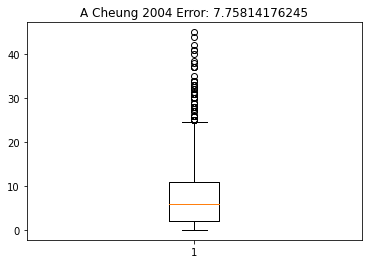

Diferencias medias
[[  6.75862069   6.93103448   6.96551724]
 [  4.72413793   4.68965517   4.4137931 ]
 [  4.03448276   3.68965517   3.5862069 ]
 [  5.44827586   5.4137931    5.68965517]
 [  9.17241379   9.44827586   9.4137931 ]
 [ 15.68965517  16.03448276  17.5       ]
 [  4.20689655   6.65517241   8.06896552]
 [  4.37931034   6.4137931    7.65517241]
 [  3.37931034   5.27586207   5.68965517]
 [  5.34482759   8.65517241   9.24137931]
 [  7.89655172  12.96551724  12.96551724]
 [ 10.27586207  14.44827586  15.44827586]
 [  6.96551724   8.62068966  13.70689655]
 [ 11.79310345  11.5862069    7.24137931]
 [  2.44827586   2.93103448   3.03448276]
 [  6.65517241   7.31034483   6.13793103]
 [  5.96551724   3.65517241   8.03448276]
 [  4.51724138   5.82758621  13.10344828]
 [  8.31034483  14.          15.89655172]
 [ 15.24137931  11.24137931  17.05172414]
 [ 10.93103448   9.86206897   5.68965517]
 [  3.27586207   3.13793103   4.96551724]
 [  3.12068966   4.48275862   4.17241379]
 [ 11.34482759 

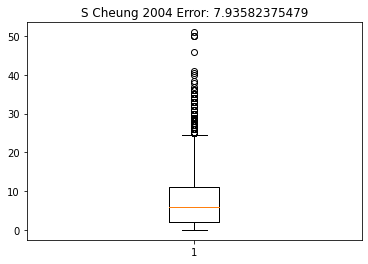

Diferencias medias
[[  9.65517241   9.06896552   9.51724138]
 [  7.34482759   7.20689655   7.        ]
 [  5.70689655   5.5862069    5.44827586]
 [  2.5862069    2.62068966   2.79310345]
 [  6.55172414   6.68965517   7.75862069]
 [ 12.27586207  12.17241379  13.75862069]
 [  1.75862069   2.93103448   4.13793103]
 [  1.62068966   2.65517241   3.72413793]
 [  3.79310345   5.51724138   6.20689655]
 [  5.10344828   6.72413793   7.68965517]
 [  5.72413793   6.72413793   7.34482759]
 [  6.51724138   8.           8.72413793]
 [  2.5862069    3.65517241   5.20689655]
 [  6.37931034   6.4137931    5.13793103]
 [  2.27586207   4.89655172   4.55172414]
 [  8.17241379   7.82758621   8.27586207]
 [  3.55172414   4.20689655   5.96551724]
 [  1.79310345   2.34482759   6.18965517]
 [  4.           7.20689655   8.27586207]
 [  7.68965517   7.17241379   8.4137931 ]
 [  4.44827586   4.17241379   3.05172414]
 [  1.22413793   1.55172414   3.03448276]
 [  2.51724138   4.20689655   4.24137931]
 [  4.81034483 

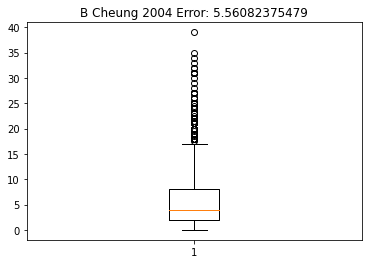

Diferencias medias
[[ 11.72413793  11.          11.17241379]
 [  8.48275862   8.20689655   7.75862069]
 [  5.51724138   5.03448276   4.75862069]
 [  3.13793103   3.10344828   3.20689655]
 [  7.10344828   7.34482759   8.13793103]
 [ 15.65517241  16.17241379  18.72413793]
 [  2.68965517   5.03448276   5.22413793]
 [  4.03448276   7.25862069   8.68965517]
 [  4.93103448   8.17241379   8.93103448]
 [  6.93103448  10.20689655  11.37931034]
 [  6.51724138   9.4137931   10.24137931]
 [  8.25862069  11.55172414  13.18965517]
 [  3.96551724   5.17241379   9.72413793]
 [ 10.44827586  10.01724138   5.5862069 ]
 [  2.89655172   4.68965517   4.55172414]
 [ 10.5862069   10.89655172   8.72413793]
 [  6.24137931   5.17241379   7.37931034]
 [  2.79310345   4.27586207   9.4137931 ]
 [  5.86206897  11.72413793  12.06896552]
 [ 13.27586207  10.03448276  14.48275862]
 [  8.43103448   8.06896552   5.20689655]
 [  2.55172414   2.93103448   6.        ]
 [  4.03448276   8.68965517   7.        ]
 [  8.93103448 

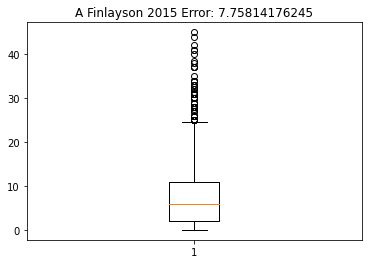

Diferencias medias
[[  6.75862069   6.93103448   6.96551724]
 [  4.72413793   4.68965517   4.4137931 ]
 [  4.03448276   3.68965517   3.5862069 ]
 [  5.44827586   5.4137931    5.68965517]
 [  9.17241379   9.44827586   9.4137931 ]
 [ 15.68965517  16.03448276  17.5       ]
 [  4.20689655   6.65517241   8.06896552]
 [  4.37931034   6.4137931    7.65517241]
 [  3.37931034   5.27586207   5.68965517]
 [  5.34482759   8.65517241   9.24137931]
 [  7.89655172  12.96551724  12.96551724]
 [ 10.27586207  14.44827586  15.44827586]
 [  6.96551724   8.62068966  13.70689655]
 [ 11.79310345  11.5862069    7.24137931]
 [  2.44827586   2.93103448   3.03448276]
 [  6.65517241   7.31034483   6.13793103]
 [  5.96551724   3.65517241   8.03448276]
 [  4.51724138   5.82758621  13.10344828]
 [  8.31034483  14.          15.89655172]
 [ 15.24137931  11.24137931  17.05172414]
 [ 10.93103448   9.86206897   5.68965517]
 [  3.27586207   3.13793103   4.96551724]
 [  3.12068966   4.48275862   4.17241379]
 [ 11.34482759 

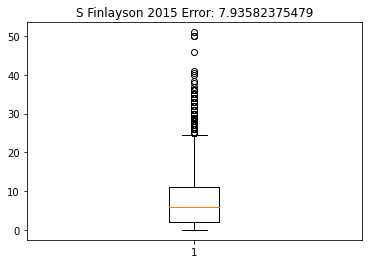

Diferencias medias
[[  9.65517241   9.06896552   9.51724138]
 [  7.34482759   7.20689655   7.        ]
 [  5.70689655   5.5862069    5.44827586]
 [  2.5862069    2.62068966   2.79310345]
 [  6.55172414   6.68965517   7.75862069]
 [ 12.27586207  12.17241379  13.75862069]
 [  1.75862069   2.93103448   4.13793103]
 [  1.62068966   2.65517241   3.72413793]
 [  3.79310345   5.51724138   6.20689655]
 [  5.10344828   6.72413793   7.68965517]
 [  5.72413793   6.72413793   7.34482759]
 [  6.51724138   8.           8.72413793]
 [  2.5862069    3.65517241   5.20689655]
 [  6.37931034   6.4137931    5.13793103]
 [  2.27586207   4.89655172   4.55172414]
 [  8.17241379   7.82758621   8.27586207]
 [  3.55172414   4.20689655   5.96551724]
 [  1.79310345   2.34482759   6.18965517]
 [  4.           7.20689655   8.27586207]
 [  7.68965517   7.17241379   8.4137931 ]
 [  4.44827586   4.17241379   3.05172414]
 [  1.22413793   1.55172414   3.03448276]
 [  2.51724138   4.20689655   4.24137931]
 [  4.81034483 

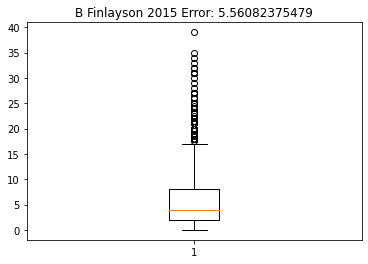

Diferencias medias
[[  2.17241379   3.17241379   3.93103448]
 [  1.68965517   1.68965517   1.62068966]
 [  3.13793103   2.89655172   2.51724138]
 [  3.79310345   3.96551724   3.86206897]
 [  4.48275862   4.           4.03448276]
 [  6.79310345   6.68965517   7.51724138]
 [  2.31034483   4.03448276   4.75862069]
 [  3.           5.68965517   7.10344828]
 [  3.24137931   6.48275862   7.4137931 ]
 [  2.72413793   5.72413793   6.13793103]
 [  3.17241379   6.13793103   6.32758621]
 [  4.24137931   7.68965517   8.86206897]
 [  2.86206897   4.10344828   8.65517241]
 [  9.13793103   8.96551724   4.03448276]
 [  1.51724138   4.17241379   3.31034483]
 [  6.03448276   6.82758621   4.48275862]
 [  4.5862069    1.62068966   5.05172414]
 [  2.10344828   3.34482759   7.06896552]
 [  4.10344828  10.48275862  11.37931034]
 [  9.82758621   5.89655172  11.89655172]
 [  6.75862069   6.17241379   3.4137931 ]
 [  2.51724138   2.86206897   5.86206897]
 [  1.89655172   7.65517241   4.96551724]
 [  7.5862069  

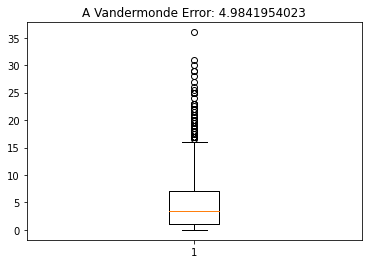

Diferencias medias
[[  4.56896552   6.27586207   6.17241379]
 [  2.72413793   3.44827586   3.55172414]
 [  2.75862069   2.86206897   2.44827586]
 [  3.68965517   3.34482759   3.93103448]
 [  6.13793103   5.17241379   5.20689655]
 [  8.62068966   7.24137931   7.68965517]
 [  3.           5.06896552   5.72413793]
 [  3.01724138   5.03448276   5.44827586]
 [  1.62068966   2.89655172   4.13793103]
 [  2.5862069    5.46551724   5.89655172]
 [  3.86206897   8.48275862   8.13793103]
 [  5.86206897   9.10344828   9.55172414]
 [  4.37931034   6.27586207  11.32758621]
 [ 10.           9.55172414   5.17241379]
 [  1.31034483   2.62068966   2.75862069]
 [  3.89655172   4.10344828   3.31034483]
 [  3.17241379   1.93103448   4.20689655]
 [  2.79310345   3.96551724  11.20689655]
 [  5.31034483  11.4137931   12.96551724]
 [ 13.10344828   9.06896552  15.48275862]
 [  9.48275862   8.72413793   4.53448276]
 [  2.24137931   1.68965517   3.55172414]
 [  1.27586207   4.24137931   3.51724138]
 [  9.03448276 

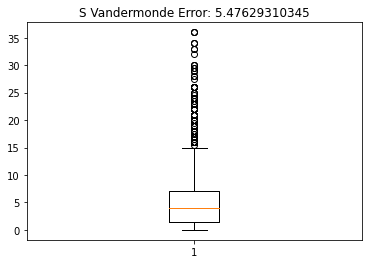

Diferencias medias
[[ 2.4137931   3.27586207  3.27586207]
 [ 2.03448276  1.86206897  1.82758621]
 [ 3.68965517  3.68965517  3.25862069]
 [ 3.10344828  3.20689655  3.44827586]
 [ 2.60344828  2.93103448  2.86206897]
 [ 4.10344828  3.51724138  4.37931034]
 [ 1.31034483  2.82758621  3.        ]
 [ 1.31034483  2.5862069   4.03448276]
 [ 2.37931034  5.15517241  5.65517241]
 [ 1.4137931   3.06896552  3.75862069]
 [ 1.62068966  2.86206897  3.24137931]
 [ 2.62068966  3.77586207  4.62068966]
 [ 2.13793103  2.93103448  6.20689655]
 [ 4.20689655  4.13793103  2.53448276]
 [ 1.65517241  4.48275862  4.55172414]
 [ 3.82758621  3.75862069  3.82758621]
 [ 1.44827586  1.55172414  2.86206897]
 [ 1.62068966  2.10344828  6.10344828]
 [ 3.06896552  6.34482759  7.34482759]
 [ 4.03448276  2.86206897  4.37931034]
 [ 3.75862069  3.68965517  1.89655172]
 [ 1.55172414  1.68965517  2.51724138]
 [ 1.31034483  2.9137931   2.17241379]
 [ 2.75862069  1.51724138  1.75862069]]


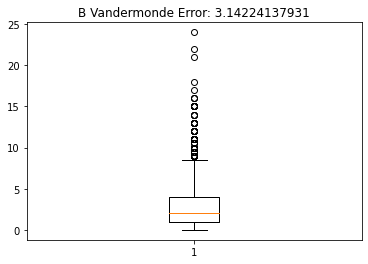

Diferencias medias
[[ 14.68965517  12.5862069   11.65517241]
 [ 10.5862069    9.36206897   8.31034483]
 [  6.72413793   6.20689655   5.62068966]
 [  4.           4.03448276   3.75862069]
 [  6.27586207   7.03448276   8.03448276]
 [ 13.89655172  14.60344828  17.65517241]
 [  2.4137931    3.79310345   5.        ]
 [  2.62068966   5.55172414   6.96551724]
 [  4.13793103   6.20689655   6.34482759]
 [  6.79310345  10.72413793  11.03448276]
 [  6.79310345  10.68965517  10.55172414]
 [  8.20689655  10.82758621  12.24137931]
 [  2.75862069   3.82758621   7.62068966]
 [ 10.72413793  10.44827586   4.68965517]
 [  2.48275862   4.37931034   4.75862069]
 [ 10.          11.96551724   9.20689655]
 [  4.03448276   4.5862069    7.93103448]
 [  2.79310345   4.37931034   7.37931034]
 [  3.65517241  10.03448276   9.06896552]
 [ 16.10344828  11.          19.03448276]
 [  8.74137931   8.86206897   3.86206897]
 [  1.5862069    1.89655172   4.75862069]
 [  6.10344828  11.37931034  10.4137931 ]
 [  7.72413793 

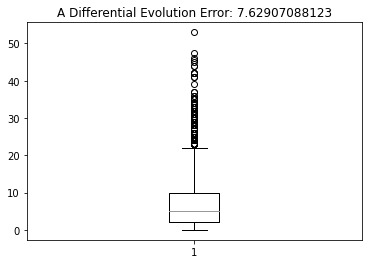

Diferencias medias
[[  6.89655172   6.5862069    6.06896552]
 [  5.24137931   4.72413793   4.        ]
 [  3.79310345   3.75862069   3.70689655]
 [  5.29310345   4.79310345   5.06896552]
 [  8.4137931    8.93103448   9.4137931 ]
 [ 14.55172414  15.          16.65517241]
 [  3.17241379   5.96551724   6.89655172]
 [  3.27586207   5.10344828   5.93103448]
 [  3.06896552   5.55172414   7.34482759]
 [  5.82758621  10.10344828  11.89655172]
 [  8.4137931   14.27586207  15.20689655]
 [ 10.44827586  14.74137931  16.46551724]
 [  5.5862069    8.24137931  12.86206897]
 [ 11.65517241  12.44827586   7.75862069]
 [  2.65517241   3.48275862   5.34482759]
 [  6.           6.93103448   5.32758621]
 [  5.65517241   5.48275862   9.62068966]
 [  3.10344828   4.75862069  13.27586207]
 [  3.79310345  11.79310345  12.13793103]
 [ 20.68965517  16.31034483  22.79310345]
 [ 10.89655172  10.79310345   5.44827586]
 [  4.65517241   3.82758621   7.56896552]
 [  5.43103448   6.37931034   8.37931034]
 [ 10.89655172 

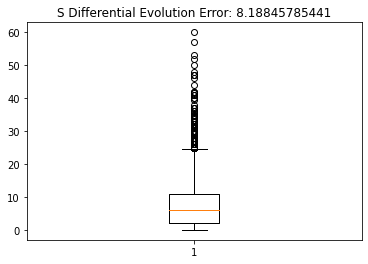

Diferencias medias
[[ 11.89655172  11.89655172  11.96551724]
 [  9.17241379   9.31034483   9.24137931]
 [  7.17241379   7.44827586   7.12068966]
 [  3.34482759   3.48275862   3.22413793]
 [  5.96551724   5.82758621   6.75862069]
 [ 11.31034483  10.93103448  11.        ]
 [  1.86206897   3.65517241   4.27586207]
 [  1.62068966   2.72413793   3.68965517]
 [  3.79310345   6.20689655   6.87931034]
 [  4.86206897   6.17241379   7.06896552]
 [  5.68965517   6.75862069   8.06896552]
 [  7.           8.43103448   9.55172414]
 [  2.44827586   3.24137931   5.89655172]
 [  5.20689655   4.86206897   2.93103448]
 [  2.96551724   6.27586207   5.93103448]
 [  7.18965517   6.55172414   6.37931034]
 [  3.17241379   3.68965517   6.48275862]
 [  2.10344828   3.06896552   6.93103448]
 [  3.           6.82758621   7.72413793]
 [  8.27586207   6.39655172  10.48275862]
 [  3.03448276   3.48275862   1.51724138]
 [  1.31034483   1.68965517   3.72413793]
 [  3.89655172   5.13793103   6.05172414]
 [  3.62068966 

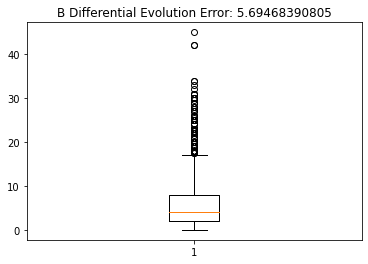

In [10]:
if os.path.exists(folder_pal_cal+"/errores_calibracion_colores.csv"):
    os.remove(folder_pal_cal+"/errores_calibracion_colores.csv")
for foldername in os.listdir(folder_pal_cal):
    if not os.path.isdir(folder_pal_cal+'/'+foldername):
        continue
    arrachera_files = [file for file in os.listdir(folder_pal_cal+'/'+foldername) if file.split('_')[1]=="A01"]
    sirloin_files = [file for file in os.listdir(folder_pal_cal+'/'+foldername) if file.split('_')[1]=="S01"]
    bola_files = [file for file in os.listdir(folder_pal_cal+'/'+foldername) if file.split('_')[1]=="B01"]
    
    for id,tipo_carne in zip(("A","S","B"),(arrachera_files,sirloin_files,bola_files)):
        if len(tipo_carne) == 0:
            continue
        medianas = np.zeros((24,len(tipo_carne),3))    
        for k,filename in enumerate(tipo_carne):
            img_paleta = cv2.imread(folder_pal_cal+'/'+foldername+'/'+filename,cv2.IMREAD_COLOR)
            img_paleta = cv2.cvtColor(img_paleta,cv2.COLOR_BGR2RGB)

            detected_circles = find_circles(img_paleta)
            if len(detected_circles) != 24:
                print("There are not 24 circles in the image")
                print(file)
                break

            circles_p,median_p = getColorsMatrix(img_paleta,detected_circles)
            for j,color in enumerate(median_p):
                medianas[j][k] = color

        vector = np.zeros((24,len(tipo_carne)-1,3))
        mean_diffs = np.zeros((24,3))
        for k in range(24):
            # print("Diferencias medias de los colores\n",np.average(np.abs(np.diff(medianas[k],axis=0)),axis=0))
            aux = np.abs(np.diff(medianas[k],axis=0))
            mean_diffs[k] = np.average(aux,axis=0)
            vector[k,:,:] = aux
        print("Diferencias medias",mean_diffs,sep='\n')
        vector = vector.flatten()
        
        plt.figure()
        plt.title(id+' '+foldername+" Error: "+str(np.average(vector)))
        plt.boxplot(vector)
        plt.show()

        with open(folder_pal_cal+"/errores_calibracion_colores.csv","a") as file:
            file.write(id+' '+foldername+",")
            file.write(",".join(vector.astype("str")))
            file.write("\n")

       

In [11]:
from scipy.stats import f_oneway

In [12]:
dct = {'A':[],'S':[],'B':[]}
with open(folder_pal_cal+"/errores_calibracion_colores.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        array = np.array(row[1:],dtype=float)
        identifier = row[0].split()[0]
        dct[identifier].append(array)
print(dct)

{'A': [array([ 10.,   7.,   6., ...,  11.,   4.,   1.]), array([ 10.,   7.,   6., ...,  11.,   4.,   1.]), array([  4.,   5.,   7., ...,  13.,   7.,   4.]), array([  7.,   6.,   7., ...,  11.,   7.,   2.])], 'S': [array([ 21.,  21.,  23., ...,  11.,   8.,   4.]), array([ 21.,  21.,  23., ...,  11.,   8.,   4.]), array([  3.,   5.,   4., ...,  10.,   5.,   0.]), array([ 26.,  24.,  19., ...,  16.,   5.,   2.])], 'B': [array([ 4.,  1.,  2., ...,  4.,  2.,  2.]), array([ 4.,  1.,  2., ...,  4.,  2.,  2.]), array([ 3. ,  3. ,  2.5, ...,  2. ,  0. ,  1. ]), array([ 8.,  3.,  1., ...,  3.,  3.,  2.])]}


In [14]:
for key,value in dct.items():
    print(key)
    result = f_oneway(*dct[key])
    print(result)

A
F_onewayResult(statistic=81.054204607310254, pvalue=1.1035153112077078e-51)
S
F_onewayResult(statistic=60.583478439417689, pvalue=9.689386821214972e-39)
B
F_onewayResult(statistic=113.68627649425353, pvalue=3.7485681391802677e-72)
